In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve
from keras.utils.vis_utils import plot_model

In [2]:
class_var = 'annontations'
features = ['Time', 'ankle-x', 'ankle-y', 'ankle-z', 
            'thigh-x', 'thigh-y', 'thigh-z',
            'trunk-x', 'trunk-y', 'trunk-z', class_var]


In [3]:
!mkdir CSV_D
for name in os.listdir('dataset_fog_release/dataset'):
    df = pd.read_csv('dataset_fog_release/dataset/' + name, header = None, sep=' ')
    df.columns = features
    df = df[df.annontations != 0]  
    name = 'CSV_D/' + name.split('.')[0]+'.csv'
    df.to_csv(name, index = None)

A subdirectory or file CSV_D already exists.


## Data Visualization

(65, 11)
(65, 11)


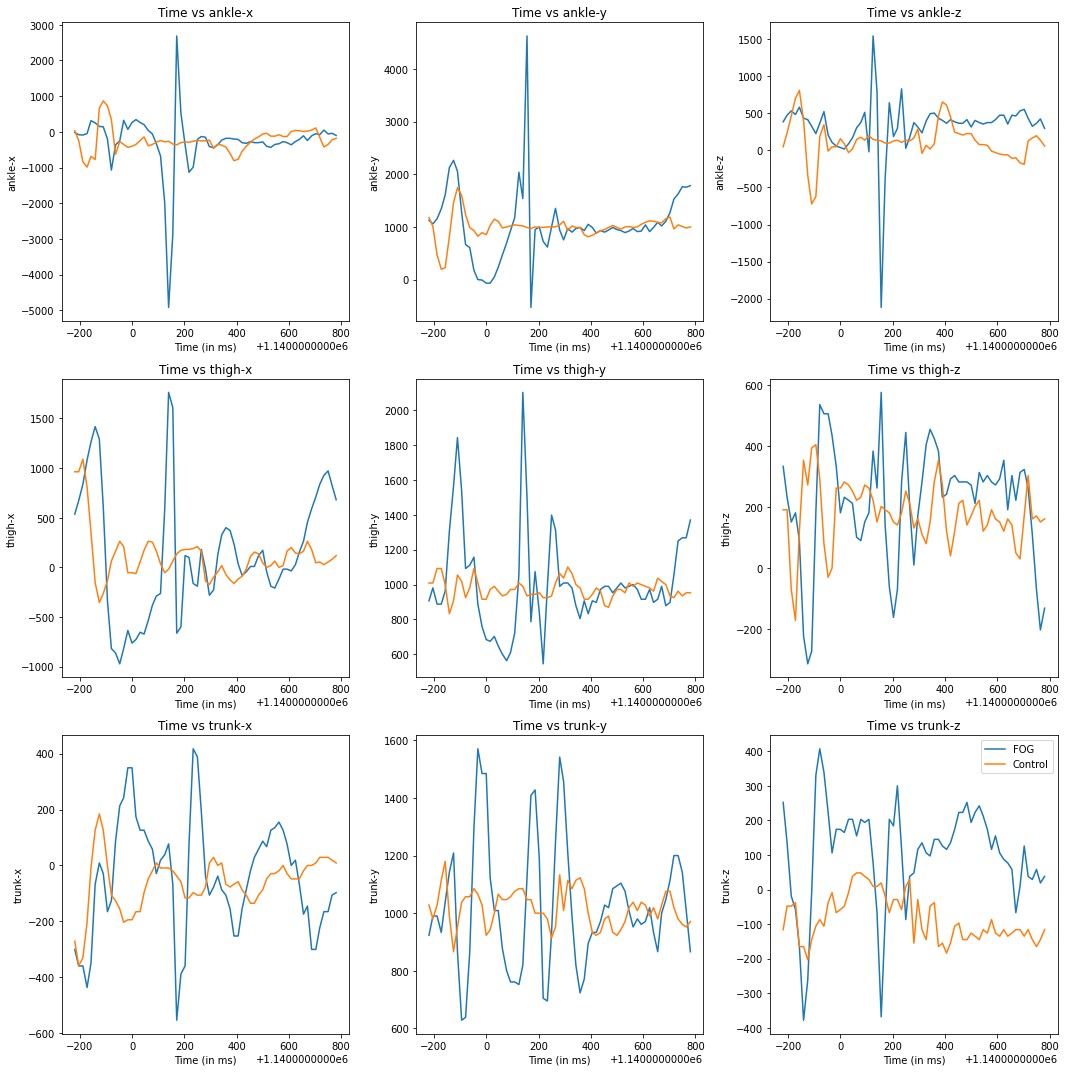

In [3]:
fog_subject = 'S01R01'
control_subject = 'S04R01'

size = 65

fog_df = pd.read_csv('CSV_D/' + fog_subject + '.csv')
fog_df = fog_df[fog_df.annontations == 2].head(size)
time_value = fog_df['Time'].to_list()[0]

fog_df = pd.read_csv('CSV_D/' + fog_subject + '.csv')
fog_df = fog_df[fog_df.Time > time_value].head(size)

control_df = pd.read_csv('CSV_D/' + control_subject + '.csv')
control_df = control_df[control_df.Time > time_value].head(size)

print(fog_df.shape)
print(control_df.shape)

nrows = 3
ncols = 3

fig = plt.gcf()
fig.set_size_inches(ncols * 5, nrows * 5)

for i, fname in enumerate(features):
  if fname != 'Time' and fname != class_var:
    plt.subplot(nrows, ncols, i)
    plt.tight_layout()
    plt.title("Time vs " + fname)
    plt.xlabel('Time (in ms)')
    plt.ylabel(fname)
    plt.plot(fog_df.Time, fog_df[fname])
    plt.plot(control_df.Time, control_df[fname])

plt.legend(["FOG", "Control",]) 
plt.show()

In [5]:
!mkdir Final_D

count = len(os.listdir('CSV_D'))

train_count = int(85/100*count)
test_count = count - train_count

print("Training Count Subjects = ", train_count)
print("Test Count Subjects = ", test_count)

category = 'train'
counter = 1

ypath = 'Final_D/y_' + category + '.txt'
yfile = open(ypath, "a")

for name in sorted(os.listdir('CSV_D')):
  if counter == train_count + 1:
    yfile.flush()
    yfile.close()
    
    category = 'test'    
    ypath = 'Final_D/y_' + category + '.txt'
    yfile = open(ypath, "a")
  print(counter, name, category)
  
  sub_data = pd.read_csv('CSV_D/' + name)
  features = sub_data.columns.to_list()
  
  full_size = 128
  overlap = 0.5
  overlap_size = int(full_size * overlap / 2)
  entry_size = full_size - overlap_size

  for i in range(0, sub_data.shape[0], entry_size):
    if sub_data.shape[0] >= i + entry_size + overlap_size:
      sub_classes = sub_data.iloc[i:i+entry_size+overlap_size, ][class_var].to_list()
      sub_class = max(sub_classes, key = sub_classes.count)
      yfile.write(str(sub_class) + "\n")
 
      for fname in features:
        if fname != 'Time' and fname != class_var:
          path_name = 'Final_D/' + category + '/'
          file_name = fname + '_' + category + '.txt'
          with open(path_name + file_name, 'a') as feat_file:
            arr = sub_data.iloc[i:i+entry_size+overlap_size, ][fname].to_numpy()
            feat_file.write(' '.join(map(str, arr)) + "\n")
  counter = counter + 1
yfile.flush()
yfile.close()

A subdirectory or file Final_D already exists.


Training Count Subjects =  14
Test Count Subjects =  3
1 S01R01.csv train
2 S01R02.csv train
3 S02R01.csv train
4 S02R02.csv train
5 S03R01.csv train
6 S03R02.csv train
7 S03R03.csv train
8 S04R01.csv train
9 S05R01.csv train
10 S05R02.csv train
11 S06R01.csv train
12 S06R02.csv train
13 S07R01.csv train
14 S07R02.csv train
15 S08R01.csv test
16 S09R01.csv test
17 S10R01.csv test


## Load Dataset - Training and Testing

In [3]:
def load_file(filepath):
	dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values

def load_category(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	loaded = np.dstack(loaded)
	return loaded

def load_dataset_category(category, prefix=''):
  filenames = []
  for fname in features:
    if fname != 'Time' and fname != class_var:
      filenames.append(category + '/' + fname + '_' + category + '.txt')
  
  X = load_category(filenames, prefix)
  y = load_file(prefix + 'y_'+ category +'.txt')
  return X, y

def load_dataset(prefix=''):
  trainX, trainy = load_dataset_category('train', prefix)
  print(trainX.shape, trainy.shape)
  testX, testy = load_dataset_category('test', prefix)
  print(testX.shape, testy.shape)
  trainy = trainy - 1
  testy = testy - 1
  neg, pos = np.bincount(trainy.reshape(1, trainy.shape[0])[0])
  total = neg + pos
  print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))
  trainy = tf.keras.utils.to_categorical(trainy)
  testy = tf.keras.utils.to_categorical(testy)
  # print(trainX.shape, trainy.shape, testX.shape, testy.shape)
  return trainX, trainy, testX, testy, neg, pos, total

In [4]:
trainX, trainy, testX, testy, neg, pos, total = load_dataset('Final_D/')
print("Training Data = ", trainX.shape)
print("Training Class = ", trainy.shape)
print("Test Data = ", testX.shape)
print("Test Class = ", testy.shape)

(7932, 128, 9) (7932, 1)
(3158, 128, 9) (3158, 1)
Examples:
    Total: 7932
    Positive: 717 (9.04% of total)

Training Data =  (7932, 128, 9)
Training Class =  (7932, 2)
Test Data =  (3158, 128, 9)
Test Class =  (3158, 2)


In [5]:
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

### FOG Model

In [6]:
verbose, epochs, batch_size = 1, 500, 32
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

DESIRED_ACCURACY = 0.97

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > DESIRED_ACCURACY:
      print("Reached " + str(DESIRED_ACCURACY*100)  + "% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='tanh', input_shape=(n_timesteps,n_features)))
model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='tanh'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='tanh', input_shape=(n_timesteps,n_features)))
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='tanh'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='tanh', input_shape=(n_timesteps,n_features)))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='tanh'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='tanh'))
model.add(tf.keras.layers.Dense(n_outputs, activation='softmax'))

model.compile(loss = 'categorical_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), 
              metrics =[tf.keras.metrics.TruePositives(name='tp'),
                        tf.keras.metrics.FalsePositives(name='fp'),
                        tf.keras.metrics.TrueNegatives(name='tn'),
                        tf.keras.metrics.FalseNegatives(name='fn'),
                        'accuracy',
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.AUC(name='auc')])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 126, 128)          3584      
                                                                 
 conv1d_1 (Conv1D)           (None, 124, 128)          49280     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 62, 128)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 60, 64)            24640     
                                                                 
 conv1d_3 (Conv1D)           (None, 58, 64)            12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 29, 64)           0         
 1D)                                                    

In [ ]:
from IPython.display import display
plot = plot_model(model, show_shapes = True, to_file = 'model.png', show_layer_names = True)
display(plot)

### Train the model

In [10]:
with tf.device('/device:GPU:0'):
  PD_history = model.fit(trainX,
                        trainy,
                        validation_data=(testX, testy),
                        epochs = epochs,
                        batch_size = batch_size,
                        verbose = verbose,
                        callbacks = [callbacks],
                        class_weight=class_weight)

Epoch 1/500
273/273 [==============================] - 17s 51ms/step - loss: 0.4751 - tp: 6227.0000 - fp: 2486.0000 - tn: 6227.0000 - fn: 2486.0000 - accuracy: 0.7147 - precision: 0.7147 - recall: 0.7147 - auc: 0.8201 - val_loss: 0.2124 - val_tp: 2813.0000 - val_fp: 345.0000 - val_tn: 2813.0000 - val_fn: 345.0000 - val_accuracy: 0.8908 - val_precision: 0.8908 - val_recall: 0.8908 - val_auc: 0.9721
Epoch 2/500
273/273 [==============================] - 18s 65ms/step - loss: 0.3389 - tp: 7291.0000 - fp: 1422.0000 - tn: 7291.0000 - fn: 1422.0000 - accuracy: 0.8368 - precision: 0.8368 - recall: 0.8368 - auc: 0.9183 - val_loss: 0.2009 - val_tp: 2855.0000 - val_fp: 303.0000 - val_tn: 2855.0000 - val_fn: 303.0000 - val_accuracy: 0.9041 - val_precision: 0.9041 - val_recall: 0.9041 - val_auc: 0.9746
Epoch 3/500
273/273 [==============================] - 20s 72ms/step - loss: 0.2975 - tp: 7544.0000 - fp: 1169.0000 - tn: 7544.0000 - fn: 1169.0000 - accuracy: 0.8658 - precision: 0.8658 - recall: 0

### Save the Model

In [11]:
model.save("Model/FOG_Final_Model.h5")
print("FOG_Model saved Successfully!")

FOG_Model saved Successfully!


In [12]:
model = tf.keras.models.load_model("Model/FOG_Final_Model.h5")

In [13]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.title('Training and Validation ' + string)
  plt.show()

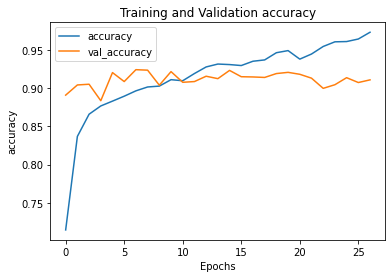

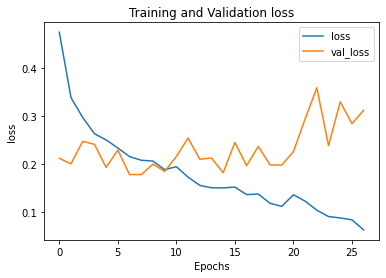

In [14]:
plot_graphs(PD_history, "accuracy")
plot_graphs(PD_history, "loss")

### Evaluation of Model

In [29]:
def model_evaluate(model, target, testX, testy):
  y_pred = model.predict(testX)
  y_pred = np.argmax(y_pred, axis=1)
  y_test = np.argmax(testy, axis=1)

  print('Confusion Matrix')
  cm = tf.math.confusion_matrix(labels = y_test, predictions = y_pred)
  # Calculate accuracy
  cm_np = cm.numpy()
  conf_acc = (cm_np[0, 0] + cm_np[1, 1])/ np.sum(cm_np) * 100
  print("Accuracy for Test Data = ", conf_acc)
  plt.figure(figsize = (12,8))
  seaborn.heatmap(cm, annot=True, fmt='d')
  plt.title("Confusion Matrix for Test Data")
  plt.xlabel('Predicted')
  plt.ylabel('Expected')
  plt.show()
  print('\nClassification Report')
  print(classification_report(y_test, y_pred))
  print('\nCohen Kappa Score')
  print(cohen_kappa_score(y_test, y_pred))
  print('\nPrecision vs Recall Curve')
  fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
  y_test = tf.keras.utils.to_categorical(y_test)
  y_pred = tf.keras.utils.to_categorical(y_pred)
  n_classes = 2

  precision = dict()
  recall = dict()

  for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                          y_pred[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
      
  plt.xlabel("recall")
  plt.ylabel("precision")
  plt.legend(loc="best")
  plt.title("Precision vs. Recall curve")
  plt.show()

  print('\nROC Curve')
  average = 'macro'
  fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
  for (idx, c_label) in enumerate(target):
      fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
      c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
  c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
  print('ROC AUC score:', roc_auc_score(y_test, y_pred, average=average))

  c_ax.legend()
  c_ax.set_xlabel('False Positive Rate')
  c_ax.set_ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.show()

Confusion Matrix
Accuracy for Test Data =  91.07029765674477


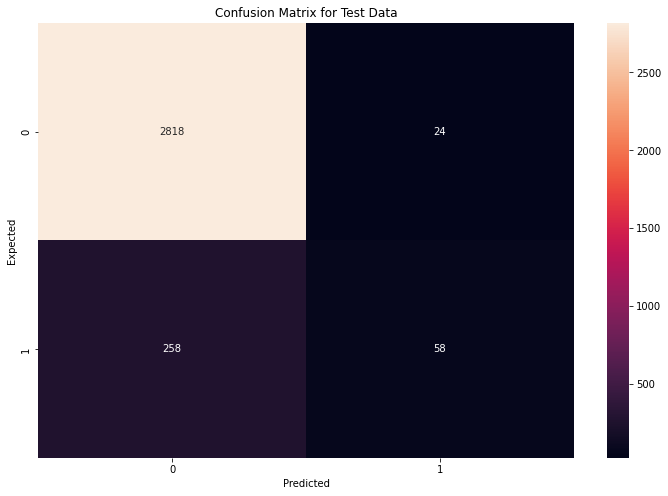


Classification Report
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      2842
           1       0.71      0.18      0.29       316

    accuracy                           0.91      3158
   macro avg       0.81      0.59      0.62      3158
weighted avg       0.90      0.91      0.89      3158


Cohen Kappa Score
0.2609861749622424

Precision vs Recall Curve


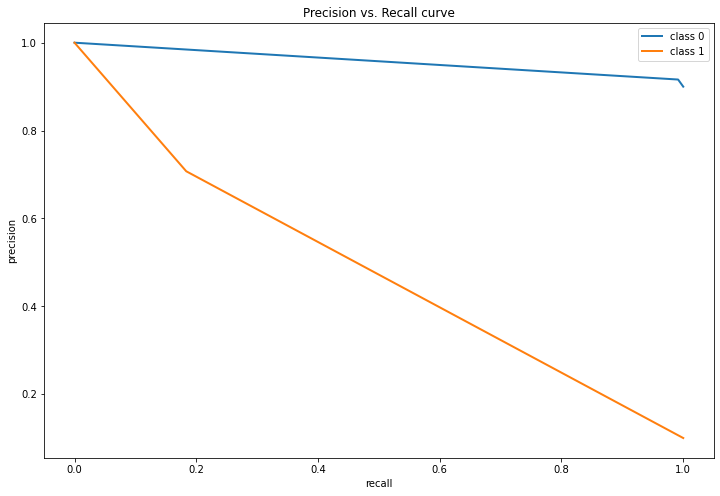


ROC Curve
ROC AUC score: 0.5875497732921191


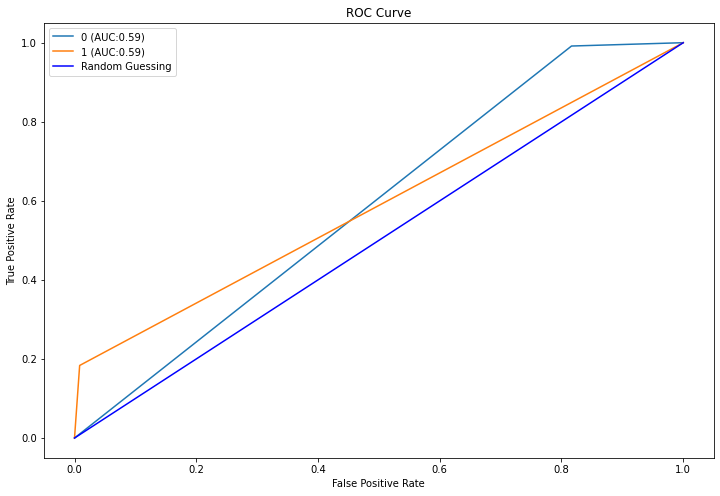

In [16]:
model_evaluate(model, [0,1], testX, testy)